This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

from sklearn.manifold import TSNE

path_prefix = ""

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root="C:\\Users\\chara\\OneDrive\\Desktop\\ML Course\\Assignment 3\\data",  train=True,download=True, transform=transform)

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

# import sys
# sys.path.insert(1, path_prefix)

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [16]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=30):

        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size):
                super(Encoder, self).__init__()
                # needs your implementation
                in_features = 28 * 28
                out_features = output_size
                self.encoder = nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=out_features)
                )

            def forward(self, x):
                # needs your implementation
                input_dimension = x.shape
                x = x.reshape(-1, input_dimension[2] * input_dimension[3])
                x = self.encoder(x)
                return x

        class Decoder(nn.Module):
            def __init__(self, input_size):
                super(Decoder, self).__init__()
                # needs your implementation
                in_features = input_size
                out_features = 28 * 28
                self.decoder = nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=out_features),
                    nn.Tanh()
                )

            def forward(self, z):
                # needs your implementation
                z = self.decoder(z)
                return z.reshape(-1, 1, 28, 28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

In [3]:
class VAE(nn.Module):

    def __init__(self,dim_latent_representation=30):

        super(VAE,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size):
                super(Encoder, self).__init__()
                # needs your implementation
                in_features = 28 * 28
                out_features = output_size
                self.linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
                self.mean_layer = nn.Linear(in_features=out_features, out_features=out_features)
                self.var_layer = nn.Linear(in_features=out_features, out_features=out_features)

            def forward(self, x):
                # needs your implementation
                input_dimension = x.shape
                x = x.reshape(-1, input_dimension[2] * input_dimension[3])
                x = self.linear_layer(x)
                mean = self.mean_layer(x)
                var = self.var_layer(x)
                return mean, var

        class Decoder(nn.Module):
            def __init__(self, input_size=30):
                super(Decoder, self).__init__()
                # needs your implementation
                in_features = input_size
                out_features = 28 * 28
                self.linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
                self.activation_layer = nn.Tanh()

            def forward(self, z):
                # needs your implementation
                z = self.linear_layer(z)
                z = self.activation_layer(z)
                return z.reshape(-1, 1, 28, 28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the VAE model
    def reparameterise(self, mu, logvar):
        # return reparametrized mu
        std = torch.exp(0.5*logvar)
        parameters = torch.randn_like(std)
        return mu + std*parameters

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        mean, var = self.encoder(x)
        x = self.reparameterise(mean, var)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x, mean, var

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [17]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

autoencoder = Autoencoder(dim_latent_representation=30)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

100%|██████████| 1875/1875 [00:05<00:00, 325.81it/s]


====> Epoch: 1 Average loss: 0.4797


100%|██████████| 313/313 [00:02<00:00, 132.59it/s]


====> Val set loss (reconstruction error) : 0.4322


100%|██████████| 1875/1875 [00:05<00:00, 345.91it/s]


====> Epoch: 2 Average loss: 0.4171


100%|██████████| 313/313 [00:02<00:00, 133.63it/s]


====> Val set loss (reconstruction error) : 0.4224


100%|██████████| 1875/1875 [00:05<00:00, 338.77it/s]


====> Epoch: 3 Average loss: 0.4128


100%|██████████| 313/313 [00:02<00:00, 135.69it/s]


====> Val set loss (reconstruction error) : 0.4205


100%|██████████| 1875/1875 [00:06<00:00, 272.39it/s]


====> Epoch: 4 Average loss: 0.4116


100%|██████████| 313/313 [00:02<00:00, 128.90it/s]


====> Val set loss (reconstruction error) : 0.4196


100%|██████████| 1875/1875 [00:05<00:00, 326.85it/s]


====> Epoch: 5 Average loss: 0.4109


100%|██████████| 313/313 [00:02<00:00, 137.41it/s]


====> Val set loss (reconstruction error) : 0.4191


100%|██████████| 1875/1875 [00:05<00:00, 316.11it/s]


====> Epoch: 6 Average loss: 0.4103


100%|██████████| 313/313 [00:02<00:00, 129.17it/s]


====> Val set loss (reconstruction error) : 0.4186


100%|██████████| 1875/1875 [00:06<00:00, 311.33it/s]


====> Epoch: 7 Average loss: 0.4099


100%|██████████| 313/313 [00:02<00:00, 146.99it/s]


====> Val set loss (reconstruction error) : 0.4182


100%|██████████| 1875/1875 [00:05<00:00, 329.82it/s]


====> Epoch: 8 Average loss: 0.4096


100%|██████████| 313/313 [00:02<00:00, 143.23it/s]


====> Val set loss (reconstruction error) : 0.4180


100%|██████████| 1875/1875 [00:05<00:00, 338.34it/s]


====> Epoch: 9 Average loss: 0.4094


100%|██████████| 313/313 [00:02<00:00, 150.66it/s]


====> Val set loss (reconstruction error) : 0.4178


100%|██████████| 1875/1875 [00:05<00:00, 332.41it/s]


====> Epoch: 10 Average loss: 0.4093


100%|██████████| 313/313 [00:02<00:00, 135.01it/s]

====> Val set loss (reconstruction error) : 0.4177


In [6]:
from VAE_starter import VAE_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 20 # the number of epochs and learning rate can be tuned.

VAE_model = VAE(dim_latent_representation=30)
vae_trainer = VAE_Trainer(VAE_model=VAE_model,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        vae_trainer.train(epoch)
        vae_trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

100%|██████████| 1875/1875 [00:09<00:00, 199.97it/s]


====> Epoch: 1 Average loss: 1.7220


100%|██████████| 313/313 [00:02<00:00, 126.43it/s]


====> Val set loss (reconstruction error) : 0.7786


100%|██████████| 1875/1875 [00:08<00:00, 231.49it/s]


====> Epoch: 2 Average loss: 0.7285


100%|██████████| 313/313 [00:02<00:00, 140.92it/s]


====> Val set loss (reconstruction error) : 0.8097


100%|██████████| 1875/1875 [00:08<00:00, 227.98it/s]


====> Epoch: 3 Average loss: 0.7174


100%|██████████| 313/313 [00:02<00:00, 143.05it/s]


====> Val set loss (reconstruction error) : 0.7420


100%|██████████| 1875/1875 [00:08<00:00, 233.10it/s]


====> Epoch: 4 Average loss: 0.7143


100%|██████████| 313/313 [00:02<00:00, 151.61it/s]


====> Val set loss (reconstruction error) : 0.7275


100%|██████████| 1875/1875 [00:08<00:00, 227.24it/s]


====> Epoch: 5 Average loss: 0.7129


100%|██████████| 313/313 [00:02<00:00, 126.84it/s]


====> Val set loss (reconstruction error) : 0.7202


100%|██████████| 1875/1875 [00:08<00:00, 224.90it/s]


====> Epoch: 6 Average loss: 0.7130


100%|██████████| 313/313 [00:02<00:00, 142.06it/s]


====> Val set loss (reconstruction error) : 0.7640


100%|██████████| 1875/1875 [00:08<00:00, 217.06it/s]


====> Epoch: 7 Average loss: 0.7126


100%|██████████| 313/313 [00:02<00:00, 144.27it/s]


====> Val set loss (reconstruction error) : 0.7180


100%|██████████| 1875/1875 [00:08<00:00, 224.22it/s]


====> Epoch: 8 Average loss: 0.7203


100%|██████████| 313/313 [00:02<00:00, 150.77it/s]


====> Val set loss (reconstruction error) : 1.7321


100%|██████████| 1875/1875 [00:08<00:00, 228.02it/s]


====> Epoch: 9 Average loss: 0.7182


100%|██████████| 313/313 [00:02<00:00, 141.35it/s]


====> Val set loss (reconstruction error) : 0.7167


100%|██████████| 1875/1875 [00:08<00:00, 229.30it/s]


====> Epoch: 10 Average loss: 0.7121


100%|██████████| 313/313 [00:02<00:00, 147.97it/s]


====> Val set loss (reconstruction error) : 0.7168


100%|██████████| 1875/1875 [00:08<00:00, 218.74it/s]


====> Epoch: 11 Average loss: 0.7122


100%|██████████| 313/313 [00:02<00:00, 149.76it/s]


====> Val set loss (reconstruction error) : 0.7172


100%|██████████| 1875/1875 [00:08<00:00, 227.49it/s]


====> Epoch: 12 Average loss: 0.7122


100%|██████████| 313/313 [00:01<00:00, 160.55it/s]


====> Val set loss (reconstruction error) : 0.7167


100%|██████████| 1875/1875 [00:08<00:00, 232.88it/s]


====> Epoch: 13 Average loss: 0.7121


100%|██████████| 313/313 [00:02<00:00, 144.55it/s]


====> Val set loss (reconstruction error) : 0.7169


100%|██████████| 1875/1875 [00:08<00:00, 231.34it/s]


====> Epoch: 14 Average loss: 0.7121


100%|██████████| 313/313 [00:02<00:00, 145.64it/s]


====> Val set loss (reconstruction error) : 0.7169


100%|██████████| 1875/1875 [00:08<00:00, 226.93it/s]


====> Epoch: 15 Average loss: 0.7121


100%|██████████| 313/313 [00:02<00:00, 147.63it/s]


====> Val set loss (reconstruction error) : 0.7166


100%|██████████| 1875/1875 [00:08<00:00, 229.34it/s]


====> Epoch: 16 Average loss: 0.7373


100%|██████████| 313/313 [00:02<00:00, 142.06it/s]


====> Val set loss (reconstruction error) : 0.7169


100%|██████████| 1875/1875 [00:08<00:00, 216.81it/s]


====> Epoch: 17 Average loss: 0.7122


100%|██████████| 313/313 [00:02<00:00, 148.82it/s]


====> Val set loss (reconstruction error) : 0.7173


100%|██████████| 1875/1875 [00:08<00:00, 231.06it/s]


====> Epoch: 18 Average loss: 0.7134


100%|██████████| 313/313 [00:02<00:00, 145.37it/s]


====> Val set loss (reconstruction error) : 0.7843


100%|██████████| 1875/1875 [00:08<00:00, 224.80it/s]


====> Epoch: 19 Average loss: 0.7125


100%|██████████| 313/313 [00:02<00:00, 145.38it/s]


====> Val set loss (reconstruction error) : 0.7168


100%|██████████| 1875/1875 [00:08<00:00, 232.97it/s]


====> Epoch: 20 Average loss: 0.7155


100%|██████████| 313/313 [00:02<00:00, 154.82it/s]

====> Val set loss (reconstruction error) : 0.9350


If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

(10000, 30)
(10000, 2)


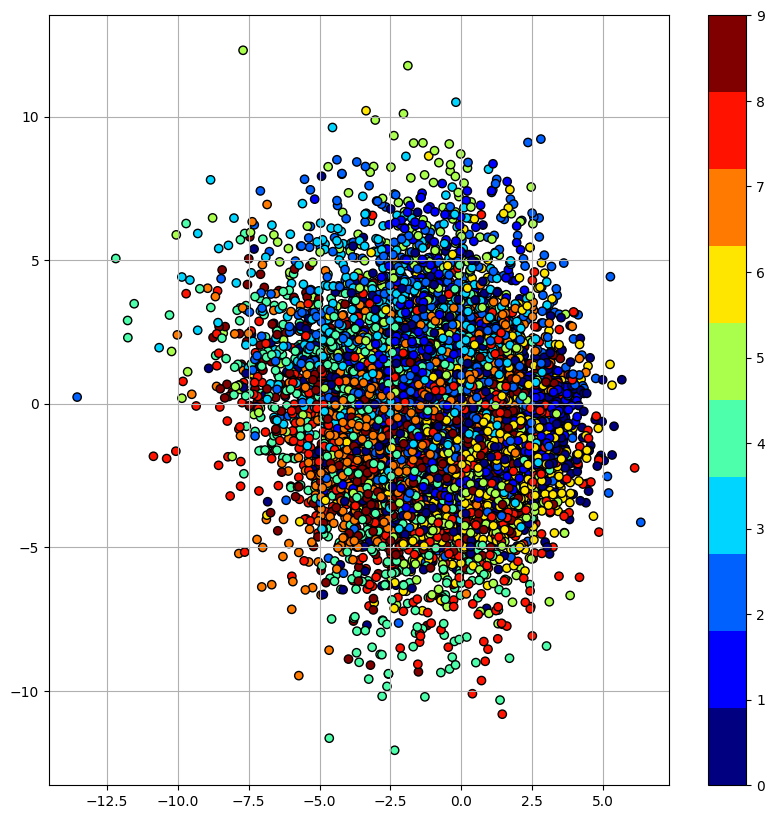

In [19]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from autoencoder_starter import scatter_plot
print(z.shape)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(z)
print(z_embedded.shape)
scatter_plot(latent_representations=z,labels=label)

(10000, 30)
(10000, 2)


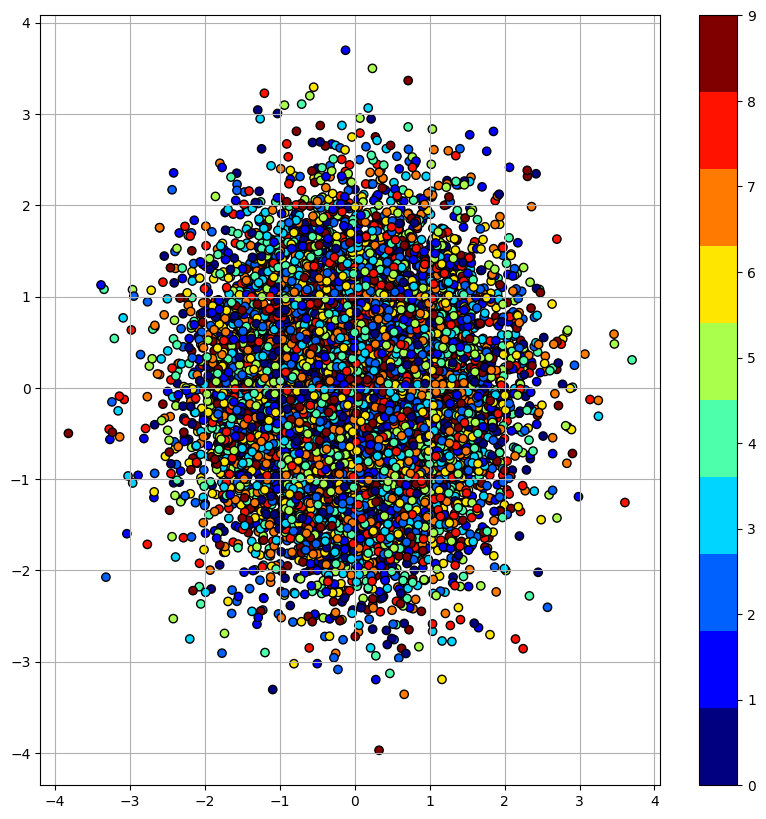

In [7]:
######## VAE model #########

with torch.no_grad():
    model = vae_trainer.model
    model.eval()
    z=[];label=[]
    for x,y in vae_trainer.val_loader:

        mean, logvar = model.encoder(x.to(vae_trainer.device))
        z_ = model.reparameterise(mean, logvar)
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from VAE_starter import scatter_plot
print(z.shape)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(z)
print(z_embedded.shape)
scatter_plot(latent_representations=z,labels=label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


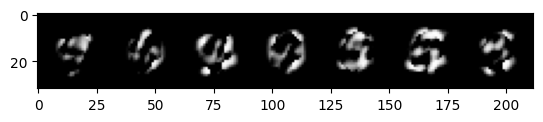

In [24]:
with torch.no_grad():
    samples = torch.randn(7, 30).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

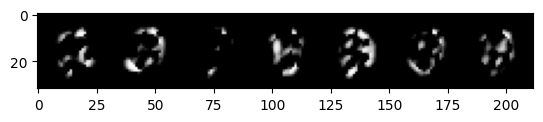

In [25]:
with torch.no_grad():
    samples = torch.randn(7, 30).to(vae_trainer.device)
    samples = vae_trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

Original images


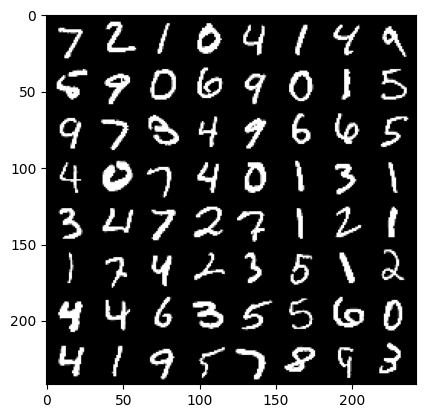

In [26]:
images = vae_trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from VAE_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


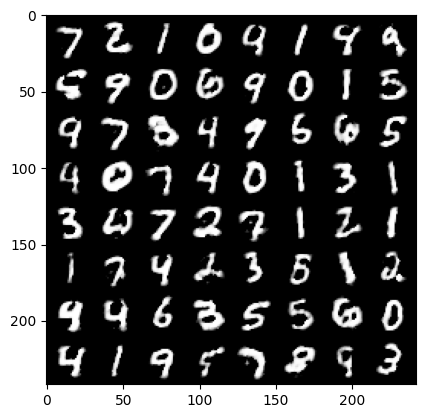

In [27]:
with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

Reconstructed images


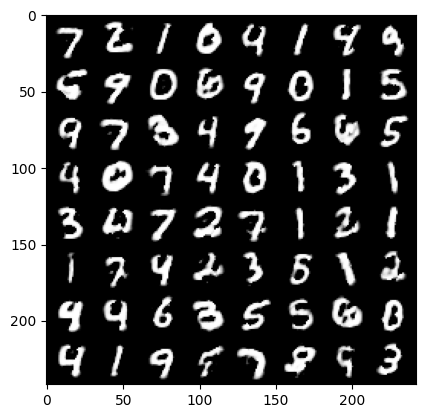

In [28]:
with torch.no_grad():
    images = images.to(vae_trainer.device)
    reconstructed = vae_trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)